## This notebook is a work in progress


# Introduction

F1 is celebrating its 70th edition in 2020. Due to the worldwide pandemic situation, the sport was affected as many other and the season is now in progress with a very unusual calendar. It is evident from the first few races how Mercedes is dominating the competition, a result somewhat expected after winning the last 6 constructor titles.

As the season unfolds, it can be expected some other team will have their day on some tracks but the curiosity about how dominant the team is remains. 

In this notebook, we will look at the historical performance of drivers and constructors to see what *dominant seasons* look like and how 2020, in all its peculiarity, compares to these seasons. This is by no means an attempt of finding who is the best driver in history or similar exercises, but rather observe how, year by year, how a driver or a constructor won the championship changed, making a season more thrilling than another.

In [1]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
pd.set_option('max_columns', 100)

/kaggle/input/formula-1-world-championship-1950-2020/status.csv
/kaggle/input/formula-1-world-championship-1950-2020/pit_stops.csv
/kaggle/input/formula-1-world-championship-1950-2020/constructor_standings.csv
/kaggle/input/formula-1-world-championship-1950-2020/qualifying.csv
/kaggle/input/formula-1-world-championship-1950-2020/lap_times.csv
/kaggle/input/formula-1-world-championship-1950-2020/races.csv
/kaggle/input/formula-1-world-championship-1950-2020/seasons.csv
/kaggle/input/formula-1-world-championship-1950-2020/constructors.csv
/kaggle/input/formula-1-world-championship-1950-2020/results.csv
/kaggle/input/formula-1-world-championship-1950-2020/circuits.csv
/kaggle/input/formula-1-world-championship-1950-2020/constructor_results.csv
/kaggle/input/formula-1-world-championship-1950-2020/drivers.csv
/kaggle/input/formula-1-world-championship-1950-2020/driver_standings.csv


In [2]:
def import_all():
    data = {}
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            name = filename.replace('.csv', '')
            data[name] = pd.read_csv(os.path.join(dirname, filename))
            
    return data


def add_ids(data, key):
    
    df = data[key]
    n_lines = df.shape[0]

    df = pd.merge(df, data['races'][['raceId', 
                                     'year', 'round', 
                                     'circuitId', 'date', 'time']], 
                  on='raceId', how='left')
    if df.shape[0] != n_lines:
        raise ValueError('Merging raceId went wrong')
        
    df = pd.merge(df, data['circuits'][['circuitId', 
                                        'circuitRef', 'location', 'country']], 
                  on='circuitId', how='left')
    if df.shape[0] != n_lines:
        raise ValueError('Merging circuitId went wrong')
        
    df = pd.merge(df, data['drivers'][['driverId', 
                                       'driverRef', 'forename', 'surname', 
                                       'dob', 'nationality']].rename(columns={'nationality': 'drv_nat'}), 
                  on='driverId', how='left')
    if df.shape[0] != n_lines:
        raise ValueError('Merging driverId went wrong')
    
    if (key != 'lap_times') and (key != 'pit_stops'):
        df = pd.merge(df, data['constructors'][['constructorId', 
                                                'constructorRef', 
                                                'name', 'nationality']].rename(columns={'nationality': 'cstr_nat'}), 
                      on='constructorId', how='left')
        if df.shape[0] != n_lines:
            raise ValueError('Merging constructorId went wrong')
        
    if key == 'results':
        df = pd.merge(df, data['status'], 
                      on='statusId', how='left')
        if df.shape[0] != n_lines:
            raise ValueError('Merging statusId went wrong')
        
    return df

In [3]:
data = import_all()

res = add_ids(data, 'results')
qual = add_ids(data, 'qualifying')
laps = add_ids(data, 'lap_times')
pits = add_ids(data, 'pit_stops')

laps.rename(columns={'time_x': 'lap_time', 'time_y': 'time'}, inplace=True)
res.rename(columns={'time_x': 'race_time', 'time_y': 'time'}, inplace=True)
pits.rename(columns={'time_x': 'pit_time', 'time_y': 'time'}, inplace=True)

laps = pd.merge(laps, res[['raceId', 'driverId', 
                           'constructorRef', 'name', 'cstr_nat']], 
                on=['raceId', 'driverId'], how='left')
pits = pd.merge(pits, res[['raceId', 'driverId', 
                           'constructorRef', 'name', 'cstr_nat']], 
                on=['raceId', 'driverId'], how='left')

res.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,race_time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,year,round,circuitId,date,time,circuitRef,location,country,driverRef,forename,surname,dob,drv_nat,constructorRef,name,cstr_nat,status
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1,2008,1,1,2008-03-16,04:30:00,albert_park,Melbourne,Australia,hamilton,Lewis,Hamilton,1985-01-07,British,mclaren,McLaren,British,Finished
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1,2008,1,1,2008-03-16,04:30:00,albert_park,Melbourne,Australia,heidfeld,Nick,Heidfeld,1977-05-10,German,bmw_sauber,BMW Sauber,German,Finished
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1,2008,1,1,2008-03-16,04:30:00,albert_park,Melbourne,Australia,rosberg,Nico,Rosberg,1985-06-27,German,williams,Williams,British,Finished
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1,2008,1,1,2008-03-16,04:30:00,albert_park,Melbourne,Australia,alonso,Fernando,Alonso,1981-07-29,Spanish,renault,Renault,French,Finished
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1,2008,1,1,2008-03-16,04:30:00,albert_park,Melbourne,Australia,kovalainen,Heikki,Kovalainen,1981-10-19,Finnish,mclaren,McLaren,British,Finished


In [4]:
res[['lap_mins', 'lap_secs']] = res['fastestLapTime'].str.split(':', expand=True)
res[['lap_secs', 'lap_millisecs']] = res['lap_secs'].str.split('.', expand=True)
res['lap_mins'] = pd.to_numeric(res['lap_mins'], errors='coerce').fillna(99)
res['lap_secs'] = pd.to_numeric(res['lap_secs'], errors='coerce').fillna(99)
res['lap_millisecs'] = pd.to_numeric(res['lap_millisecs'], errors='coerce').fillna(99)

res['fastestLapTime_ms'] = (60 * res['lap_mins'] + res['lap_secs']) * 1000 + res['lap_millisecs']

res['race_fastestTime'] = res.groupby('raceId').fastestLapTime_ms.transform('min')
res['FastLap'] = np.where(res['race_fastestTime'] == res['fastestLapTime_ms'], 1, 0)

res.drop(['lap_mins', 'lap_secs', 'lap_millisecs'], axis=1, inplace=True)

points = {1: 25, 2: 18, 3: 15, 4: 12, 5: 10, 6: 8, 7: 6, 8: 4, 9: 2, 10: 1}

res['points'] = res['positionOrder'].map(points).fillna(0)
#res.loc[res.FastLap == 1, 'points'] = res['points'] + 1

res['fastestLap'] = pd.to_numeric(res['fastestLap'], errors='coerce')

res['DriverName'] = res['forename'].str[0] + '. ' + res['surname']


res['net_gain'] = -(res['positionOrder'] - res['grid'])
res['abs_gain'] = abs(res['net_gain'])

res['finished'] = np.where(res.status == 'Finished', 1, 0)

In [5]:
def plot_frame(ax):
    ax.set_facecolor('#292525')
    ax.spines['bottom'].set_color('w')
    ax.tick_params(axis='x', colors='w')
    ax.xaxis.label.set_color('w')
    ax.spines['left'].set_color('w')
    ax.tick_params(axis='y', colors='w')
    ax.yaxis.label.set_color('w')
    return ax

def get_drv_ann(data, year, ax, adjust, count=False, measure='Pts.'):
    
    yr_data = data[data.year==year].groupby(['driverId', 'DriverName', 'name']).points.sum().sort_values(ascending=False)
    if count:
        yr_data = data[data.year==year].groupby(['driverId', 'DriverName', 'name']).resultId.count().sort_values(ascending=False)
    drv_name = yr_data.index[0][1]
    ctr_name = yr_data.index[0][2]
    pts = yr_data[0]
    value = pts / data[data.year==year].raceId.nunique()
    
    text = f'{drv_name}\n{ctr_name}, {year}\n{int(pts)} {measure}'
    
    ax.annotate(text, xy=(year, value), xycoords='data', xytext=adjust, textcoords='offset points', color='w')
    
    return ax


def get_ctr_ann(data, year, ax, adjust, count=False, measure='Pts.'):
    
    yr_data = data[data.year==year].groupby(['name']).points.sum().sort_values(ascending=False)
    if count:
        yr_data = data[data.year==year].groupby(['name']).resultId.count().sort_values(ascending=False)
    ctr_name = yr_data.index[0]
    pts = yr_data[0]
    value = pts / data[data.year==year].raceId.nunique()
    
    text = f'{ctr_name}, {year}\n{int(pts)} {measure}'
    
    ax.annotate(text, xy=(year, value), xycoords='data', xytext=adjust, textcoords='offset points', color='w')
    
    return ax


def plot_bars(bars, ax, color):
    
    colors = [color if (c == 2020) else 'w' for c in bars.index]
    bars.plot(color=colors, kind='bar', ax=ax)
    ax.set_title('Top Years vs 2020', fontsize=14, color='w')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    
    return ax

# The best drivers and the best cars

To compare cars and drivers of different eras we have to take into account a few things:
* The point system changed
* Some years the fastest lap was awarded with one extra point, thus giving one more reason to aim for it
* Each season has a different number of races

Therefore, we assigned all the points with the current system (25 to the winner, 18 to p2, etc) and consider some statistics by weighting them on the number of Gran Prix of each season. Since the lap time was not recorded consistently across the years, we ignore the extra point for fastest lap.

The 2020 season has being already a very peculiar one due to reasons outside of the F1 control. However, we will see how the Mercedes dominance in 2020 is somewhat unprecedented in the history of the sport.

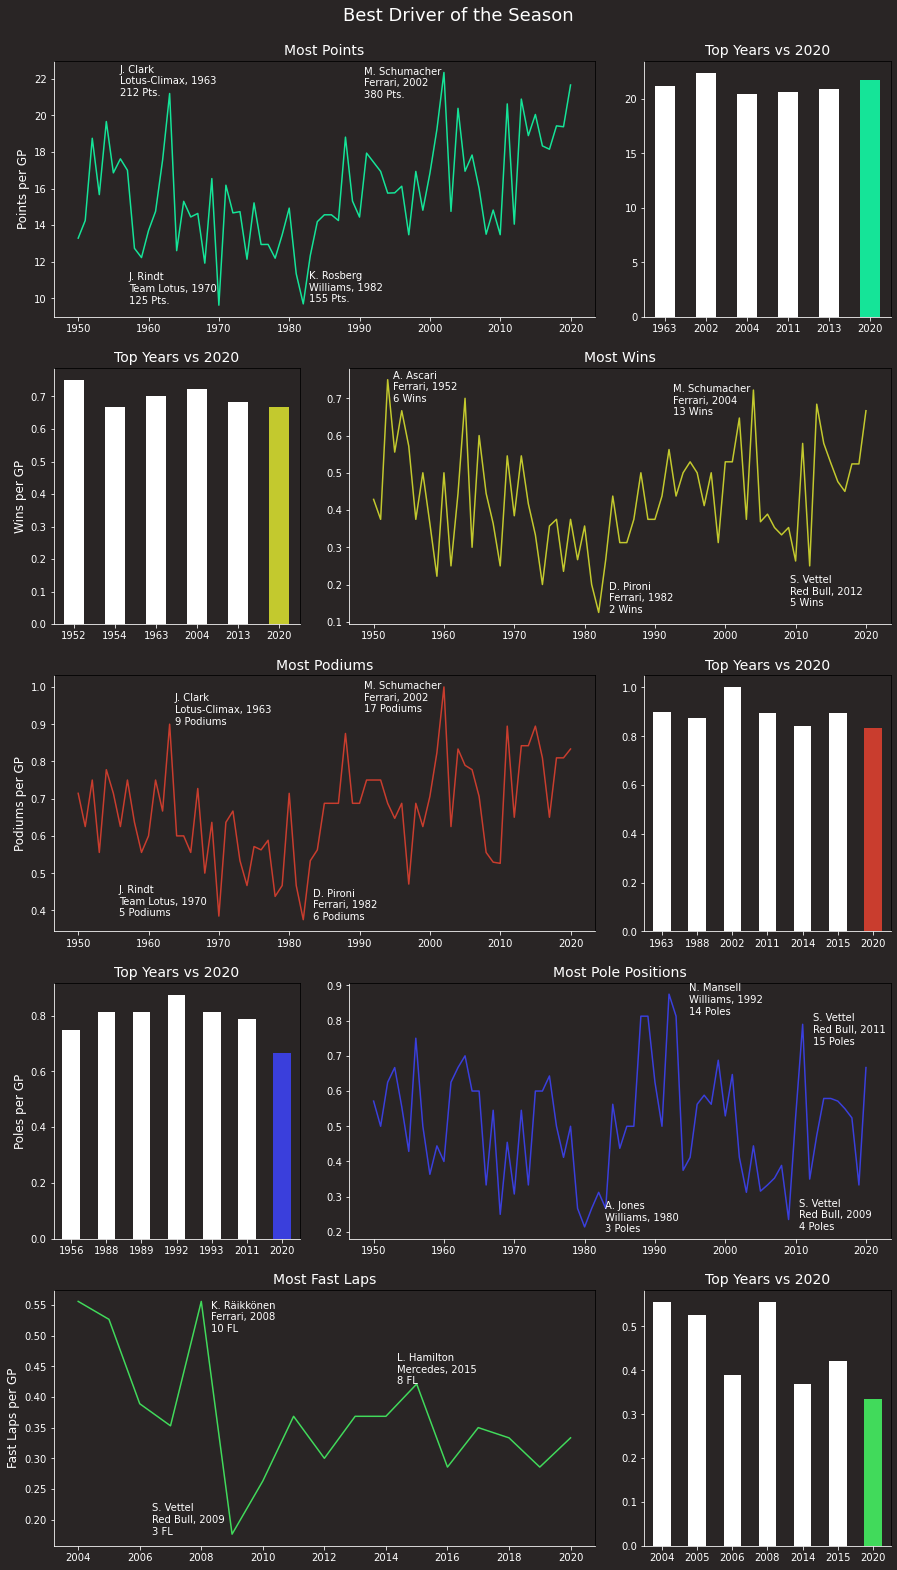

In [6]:
fig = plt.figure(figsize=(15, 25), facecolor='#292525')
fig.subplots_adjust(top=0.95)
fig.suptitle('Best Driver of the Season', fontsize=18, color='w')

gs = GridSpec(5, 3, figure=fig)
ax0 = fig.add_subplot(gs[0, :2])
ax1 = fig.add_subplot(gs[0, 2])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1:])
ax4 = fig.add_subplot(gs[2, :2])
ax5 = fig.add_subplot(gs[2, 2])
ax6 = fig.add_subplot(gs[3, 0])
ax7 = fig.add_subplot(gs[3, 1:])
ax8 = fig.add_subplot(gs[4, :2])
ax9 = fig.add_subplot(gs[4, 2])

race_counts = res.groupby(['year']).raceId.nunique()

(res.groupby(['year', 'driverId']).points.sum().groupby('year').max() / race_counts).plot(ax=ax0, color='#15E498')
ax0.set_title('Most Points', fontsize=14, color='w')
ax0.set_ylabel('Points per GP', fontsize=12)
ax0 = get_drv_ann(res, 2002, ax0, (-80, -25))
ax0 = get_drv_ann(res, 1963, ax0, (-50, -2))
ax0 = get_drv_ann(res, 1970, ax0, (-90, 2))
ax0 = get_drv_ann(res, 1982, ax0, (6, 2))

years = (res.groupby(['year', 'driverId']).points.sum().groupby('year').max() / race_counts).sort_values()[-6:].index.to_list()
if 2020 not in years:
    years += [2020]
bars = (res[res.year.isin(years)].groupby(['year', 'DriverName']).points.sum().groupby(['year']).max() / race_counts).dropna()
ax1 = plot_bars(bars, ax1, '#15E498')

(res[res.positionOrder == 1].groupby(['year', 'driverId']).resultId.count().groupby('year').max() / race_counts).plot(ax=ax3, color='#C3C92E')
ax3.set_title('Most Wins', fontsize=14, color='w')
ax2.set_ylabel('Wins per GP', fontsize=12)
ax3 = get_drv_ann(res[res.positionOrder == 1], 1952, ax3, (5, -22), count=True, measure='Wins')
ax3 = get_drv_ann(res[res.positionOrder == 1], 2004, ax3, (-80, -25), count=True, measure='Wins')
ax3 = get_drv_ann(res[res.positionOrder == 1], 1982, ax3, (10, 0), count=True, measure='Wins')
ax3 = get_drv_ann(res[res.positionOrder == 1], 2012, ax3, (-20, -40), count=True, measure='Wins')

years = (res[res.positionOrder == 1].groupby(['year', 'driverId']).resultId.count().groupby('year').max() / race_counts).sort_values()[-6:].index.to_list()
if 2020 not in years:
    years += [2020]
bars = (res[(res.positionOrder == 1) & (res.year.isin(years))].groupby(['year', 'DriverName']).resultId.count().groupby(['year']).max() / race_counts).dropna()
ax2 = plot_bars(bars, ax2, '#C3C92E')

(res[res.positionOrder <= 3].groupby(['year', 'driverId']).resultId.count().groupby('year').max() / race_counts).plot(ax=ax4, color='#C93D2E')
ax4.set_title('Most Podiums', fontsize=14, color='w')
ax4.set_ylabel('Podiums per GP', fontsize=12)
ax4 = get_drv_ann(res[res.positionOrder <= 3], 2002, ax4, (-80, -25), count=True, measure='Podiums')
ax4 = get_drv_ann(res[res.positionOrder <= 3], 1963, ax4, (5, 0), count=True, measure='Podiums')
ax4 = get_drv_ann(res[res.positionOrder <= 3], 1982, ax4, (10, 0), count=True, measure='Podiums')
ax4 = get_drv_ann(res[res.positionOrder <= 3], 1970, ax4, (-100, 0), count=True, measure='Podiums')

years = (res[res.positionOrder <= 3].groupby(['year', 'driverId']).resultId.count().groupby('year').max() / race_counts).sort_values()[-6:].index.to_list()
if 2020 not in years:
    years += [2020]
bars = (res[(res.positionOrder <= 3) & (res.year.isin(years))].groupby(['year', 'DriverName']).resultId.count().groupby(['year']).max() / race_counts).dropna()
ax5 = plot_bars(bars, ax5, '#C93D2E')

(res[res.grid == 1].groupby(['year', 'driverId']).resultId.count().groupby('year').max() / race_counts).plot(ax=ax7, color='#3A3FDC')
ax7.set_title('Most Pole Positions', fontsize=14, color='w')
ax6.set_ylabel('Poles per GP', fontsize=12)
ax7 = get_drv_ann(res[res.grid == 1], 2011, ax7, (10, -20), count=True, measure='Poles')
ax7 = get_drv_ann(res[res.grid == 1], 2009, ax7, (10, -10), count=True, measure='Poles')
ax7 = get_drv_ann(res[res.grid == 1], 1992, ax7, (20, -20), count=True, measure='Poles')
ax7 = get_drv_ann(res[res.grid == 1], 1980, ax7, (20, -5), count=True, measure='Poles')

years = (res[res.grid == 1].groupby(['year', 'driverId']).resultId.count().groupby('year').max() / race_counts).sort_values()[-6:].index.to_list()
if 2020 not in years:
    years += [2020]
bars = (res[(res.grid == 1) & (res.year.isin(years))].groupby(['year', 'DriverName']).resultId.count().groupby(['year']).max() / race_counts).dropna()
ax6 = plot_bars(bars, ax6, '#3A3FDC')

(res[res['rank'] == '1'].groupby(['year', 'driverId']).resultId.count().groupby('year').max() / race_counts).plot(ax=ax8, color='#41DA5B')
ax8.set_title('Most Fast Laps', fontsize=14, color='w')
ax8.set_ylabel('Fast Laps per GP', fontsize=12)
ax8 = get_drv_ann(res[res['rank'] == '1'], 2009, ax8, (-80, 0), count=True, measure='FL')
ax8 = get_drv_ann(res[res['rank'] == '1'], 2008, ax8, (10, -30), count=True, measure='FL')
ax8 = get_drv_ann(res[res['rank'] == '1'], 2015, ax8, (-20, 0), count=True, measure='FL')

years = (res[res['rank'] == '1'].groupby(['year', 'driverId']).resultId.count().groupby('year').max() / race_counts).dropna().sort_values()[-6:].index.to_list()
if 2020 not in years:
    years += [2020]
bars = (res[(res['rank'] == '1') & (res.year.isin(years))].groupby(['year', 'DriverName']).resultId.count().groupby(['year']).max() / race_counts).dropna()
ax9 = plot_bars(bars, ax9, '#41DA5B')

for ax in [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]:
    ax = plot_frame(ax)
    ax.set_xlabel('')

plt.show()

In these plots we see how the best driver in each statistic performed year by year. For example, in 1952 the driver that won the most Gran Prix was Ascari with 6 wins and his percentage of victories in one season is still unbeaten. Moreover, we observe that

* The 2002 and 2004 seasons were both golden seasons for **Michael Schumacher** and its **Ferrari**, collecting and unprecedented number of points, podiums, and victories. He even beats the legendary 1963 season of **Jim Clark** in Lotus. 
* On the other hand, the 1982 season is the one won by the driver that achieved the lowest number of points, podiums, and victories per GP. We will see later how peculiar such season was.
* In qualify, the absolute dominance of Nigel Mansel and its Williams in 1992 and of Sebastian Vettel in Red Bull in 2011 are evident, with 14 and 15 pole positions. Under this aspect, the 2020 season has not been exceptional, given the rivalrly between the Mercedes drivers.
* On the other hand, Sebastian Vettel was the driver with most poles in 2009 but also one of the drivers that achieved the least pole positions among the top drivers of each year.

Another way to read the charts above is considering that **the higher the top driver of a season ranks in those statistics, the more he dominated the competition that year**. And the lower a driver ranks, the bigger (or the closer) the competition was that year.

2020 has been so far a pretty uncompetitive season, which is evident to anyone watching the Gran Prix and the dominance Lewis Hamilton is showing in terms of points, podiums, and fastest laps.

If we have a look at the constructors.

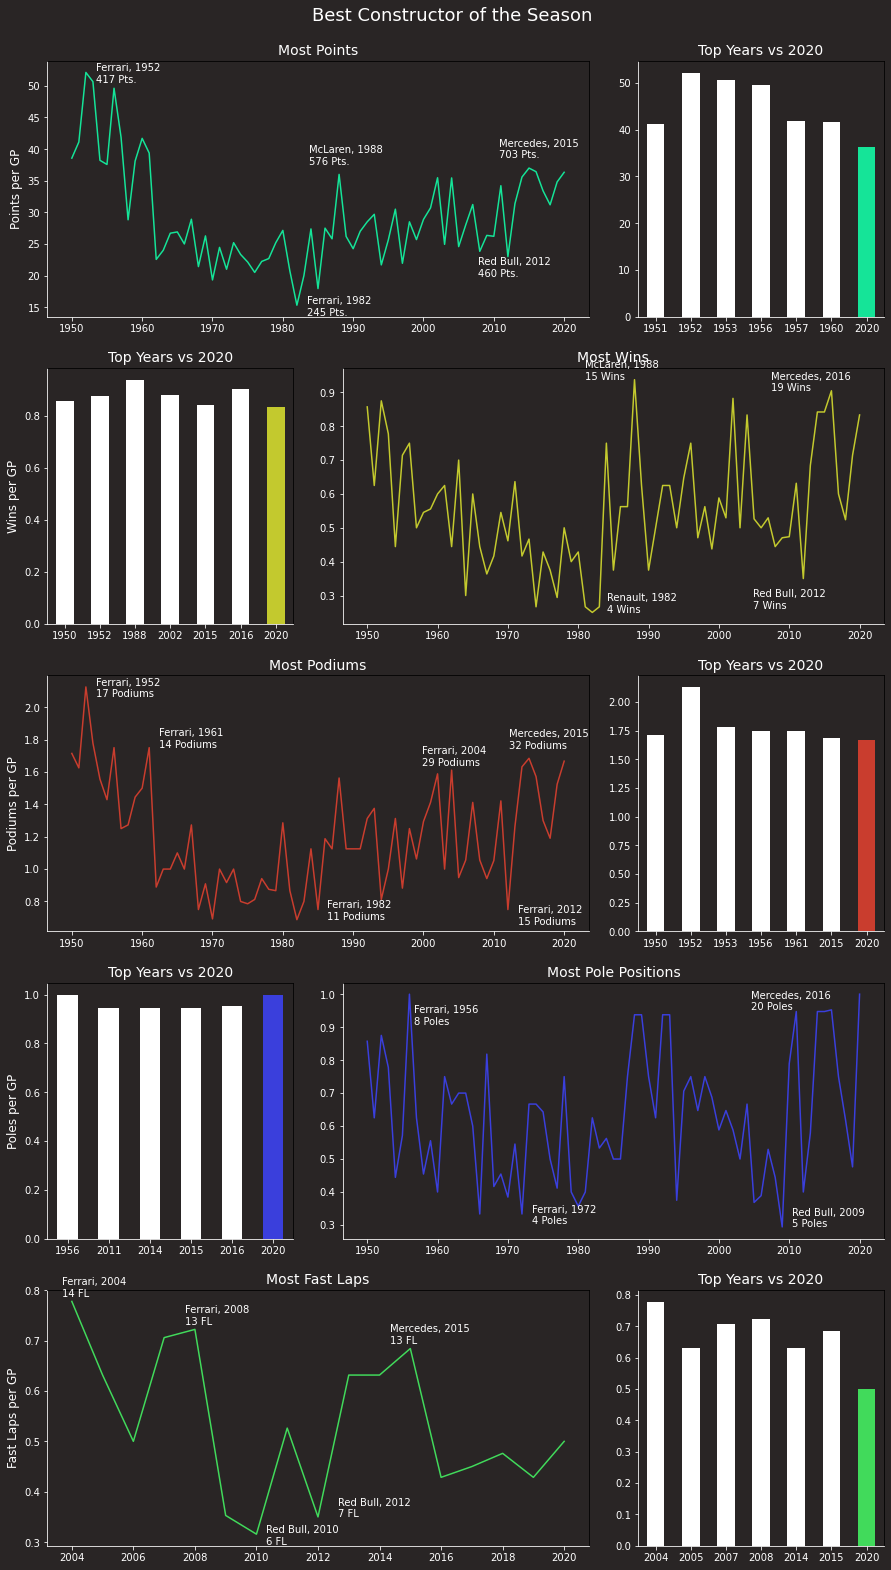

In [7]:
fig = plt.figure(figsize=(15, 25), facecolor='#292525')
fig.subplots_adjust(top=0.95)
fig.suptitle('Best Constructor of the Season', fontsize=18, color='w')

gs = GridSpec(5, 3, figure=fig)
ax0 = fig.add_subplot(gs[0, :2])
ax1 = fig.add_subplot(gs[0, 2])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1:])
ax4 = fig.add_subplot(gs[2, :2])
ax5 = fig.add_subplot(gs[2, 2])
ax6 = fig.add_subplot(gs[3, 0])
ax7 = fig.add_subplot(gs[3, 1:])
ax8 = fig.add_subplot(gs[4, :2])
ax9 = fig.add_subplot(gs[4, 2])

race_counts = res.groupby(['year']).raceId.nunique()

(res.groupby(['year', 'constructorId']).points.sum().groupby('year').max() / race_counts).plot(ax=ax0, color='#15E498')
ax0.set_title('Most Points', fontsize=14, color='w')
ax0.set_ylabel('Points per GP', fontsize=12)
ax0 = get_ctr_ann(res, 1952, ax0, (10, -10))
ax0 = get_ctr_ann(res, 1982, ax0, (10, -10))
ax0 = get_ctr_ann(res, 2015, ax0, (-30, 10))
ax0 = get_ctr_ann(res, 1988, ax0, (-30, 10))
ax0 = get_ctr_ann(res, 2012, ax0, (-30, -20))

years = (res.groupby(['year', 'constructorId']).points.sum().groupby('year').max() / race_counts).sort_values()[-6:].index.to_list()
if 2020 not in years:
    years += [2020]
bars = (res[res.year.isin(years)].groupby(['year', 'name']).points.sum().groupby(['year']).max() / race_counts).dropna()
ax1 = plot_bars(bars, ax1, '#15E498')

(res[res.positionOrder == 1].groupby(['year', 'constructorId']).resultId.count().groupby('year').max() / race_counts).plot(ax=ax3, color='#C3C92E')
ax3.set_title('Most Wins', fontsize=14, color='w')
ax2.set_ylabel('Wins per GP', fontsize=12)
ax3 = get_ctr_ann(res[res.positionOrder == 1], 1988, ax3, (-50,0), count=True, measure='Wins')
ax3 = get_ctr_ann(res[res.positionOrder == 1], 2016, ax3, (-60,0), count=True, measure='Wins')
ax3 = get_ctr_ann(res[res.positionOrder == 1], 1982, ax3, (15,0), count=True, measure='Wins')
ax3 = get_ctr_ann(res[res.positionOrder == 1], 2012, ax3, (-50,-30), count=True, measure='Wins')

years = (res[res.positionOrder == 1].groupby(['year', 'constructorId']).resultId.count().groupby('year').max() / race_counts).sort_values()[-6:].index.to_list()
if 2020 not in years:
    years += [2020]
bars = (res[(res.positionOrder == 1) & (res.year.isin(years))].groupby(['year', 'name']).resultId.count().groupby(['year']).max() / race_counts).dropna()
ax2 = plot_bars(bars, ax2, '#C3C92E')

(res[res.positionOrder <= 3].groupby(['year', 'constructorId']).resultId.count().groupby('year').max() / race_counts).plot(ax=ax4, color='#C93D2E')
ax4.set_title('Most Podiums', fontsize=14, color='w')
ax4.set_ylabel('Podiums per GP', fontsize=12)
ax4 = get_ctr_ann(res[res.positionOrder <= 3], 1952, ax4, (10,-10), count=True, measure='Podiums')
ax4 = get_ctr_ann(res[res.positionOrder <= 3], 1961, ax4, (10,0), count=True, measure='Podiums')
ax4 = get_ctr_ann(res[res.positionOrder <= 3], 1982, ax4, (30,0), count=True, measure='Podiums')
ax4 = get_ctr_ann(res[res.positionOrder <= 3], 2012, ax4, (10,-15), count=True, measure='Podiums')
ax4 = get_ctr_ann(res[res.positionOrder <= 3], 2004, ax4, (-30,5), count=True, measure='Podiums')
ax4 = get_ctr_ann(res[res.positionOrder <= 3], 2015, ax4, (-20,10), count=True, measure='Podiums')

years = (res[res.positionOrder <= 3].groupby(['year', 'constructorId']).resultId.count().groupby('year').max() / race_counts).sort_values()[-6:].index.to_list()
if 2020 not in years:
    years += [2020]
bars = (res[(res.positionOrder <= 3) & (res.year.isin(years))].groupby(['year', 'name']).resultId.count().groupby(['year']).max() / race_counts).dropna()
ax5 = plot_bars(bars, ax5, '#C93D2E')

(res[res.grid == 1].groupby(['year', 'constructorId']).resultId.count().groupby('year').max() / race_counts).plot(ax=ax7, color='#3A3FDC')
ax7.set_title('Most Pole Positions', fontsize=14, color='w')
ax6.set_ylabel('Poles per GP', fontsize=12)
ax7 = get_ctr_ann(res[res.grid == 1], 2009, ax7, (10,0), count=True, measure='Poles')
ax7 = get_ctr_ann(res[res.grid == 1], 1972, ax7, (10,-10), count=True, measure='Poles')
ax7 = get_ctr_ann(res[res.grid == 1], 1956, ax7, (5,-30), count=True, measure='Poles')
ax7 = get_ctr_ann(res[res.grid == 1], 2016, ax7, (-80,0), count=True, measure='Poles')

years = (res[res.grid == 1].groupby(['year', 'constructorId']).resultId.count().groupby('year').max() / race_counts).sort_values()[-6:].index.to_list()
if 2020 not in years:
    years += [2020]
bars = (res[(res.grid == 1) & (res.year.isin(years))].groupby(['year', 'name']).resultId.count().groupby(['year']).max() / race_counts).dropna()
ax6 = plot_bars(bars, ax6, '#3A3FDC')

(res[res['rank'] == '1'].groupby(['year', 'constructorId']).resultId.count().groupby('year').max() / race_counts).plot(ax=ax8, color='#41DA5B')
ax8.set_title('Most Fast Laps', fontsize=14, color='w')
ax8.set_ylabel('Fast Laps per GP', fontsize=12)
ax8 = get_ctr_ann(res[res['rank'] == '1'], 2010, ax8, (10,-10), count=True, measure='FL')
ax8 = get_ctr_ann(res[res['rank'] == '1'], 2012, ax8, (20,0), count=True, measure='FL')
ax8 = get_ctr_ann(res[res['rank'] == '1'], 2004, ax8, (-10,5), count=True, measure='FL')
ax8 = get_ctr_ann(res[res['rank'] == '1'], 2008, ax8, (-10,5), count=True, measure='FL')
ax8 = get_ctr_ann(res[res['rank'] == '1'], 2015, ax8, (-20,5), count=True, measure='FL')

years = (res[res['rank'] == '1'].groupby(['year', 'constructorId']).resultId.count().groupby('year').max() / race_counts).dropna().sort_values()[-6:].index.to_list()
if 2020 not in years:
    years += [2020]
bars = (res[(res['rank'] == '1') & (res.year.isin(years))].groupby(['year', 'name']).resultId.count().groupby(['year']).max() / race_counts).dropna()
ax9 = plot_bars(bars, ax9, '#41DA5B')

for ax in [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]:
    ax = plot_frame(ax)
    ax.set_xlabel('')

plt.show()

* Mercedes in 2020 is showing a dominance that was **unseen since the 1960's**. This is actually a clear trend since the past few years, seasons where they were able to achieve up to 90% of the victories (2016, 19 wins). 
* The 2018 season is an exception, with Ferrari getting pretty close and making the season more thrilling.
* Worth mentioning the dominant performances of **1988 McLaren** and **2004 Ferrari**
* On the other hand, the constructor race was pretty close in 2012, the most competitive year in recent history
* 1982 shows once again how competitive the season was.


# Season by season

With these first insights, we can have a look at how the mentioned seasons unfolded for the driver and constructor championships. Please remember that the points are calculated on the current rules, not necessarily the rules used in the given season.

In [8]:
def annotate_season(data, ax, tp='Driver'):
    
    text = f'Top {tp} \n'
    for name, points in data.iteritems():
        text += f'{name} {(int(points))}\n'
    
    ax.text(0.05, 0.65, text, transform=ax.transAxes, color='w', fontsize=13)
    
    return ax


def plot_season(res, year, n_drivers, n_ctr, drv_colors, ctr_colors):
    fig, ax = plt.subplots(2, 1, figsize=(15, 10), facecolor='#292525')
    fig.subplots_adjust(top=0.92)
    fig.suptitle(f'{year} Season', fontsize=18, color='w')
    
    drivers = res[res.year==year].groupby('DriverName').points.sum().sort_values()[-n_drivers:].index

    tmp = res[(res.year==year)].sort_values(by=['round'])
    
    to_print = tmp.groupby('DriverName').points.sum().sort_values(ascending=False)[:n_drivers]

    tmp['tot_points'] = tmp.groupby('driverId').points.cumsum()
    tmp = tmp.set_index('raceId')
    i = 0
    for driver in tmp.DriverName.unique():
        if driver in drivers:
            color = drv_colors[i]
            i += 1
        else:
            color = '#7C7373'
        tmp[tmp.DriverName == driver].tot_points.plot(ax=ax[0], color=color)
        
    ax[0] = annotate_season(to_print, ax[0])
           
    constr = res[res.year==year].groupby('name').points.sum().sort_values()[-n_ctr:].index

    tmp = res[(res.year==year)].groupby(['raceId', 'constructorId', 'name'], as_index=False).points.sum().sort_values(by=['raceId'])
    
    to_print = tmp.groupby('name').points.sum().sort_values(ascending=False)[:n_ctr]

    tmp['tot_points'] = tmp.groupby('constructorId').points.cumsum()
    tmp = tmp.set_index('raceId')
    i = 0
    for ctr in tmp.name.unique():
        if ctr in constr:
            color = ctr_colors[i]
            i += 1
        else:
            color = '#7C7373'
        tmp[tmp.name == ctr].tot_points.plot(ax=ax[1], color=color)
        
    ax[1] = annotate_season(to_print, ax[1], tp='Constructor')
        
    ax[0].set_title('Driver Title', fontsize=14, color='w')
    ax[1].set_title('Constructor Title', fontsize=14, color='w')
    
    for axes in ax:
        axes = plot_frame(axes)
        axes.set_xlabel('')
        axes.set_xticks([])
        
    plt.show()
    
    
clrs = {'Ferrari': '#ff2800', 
        'Red Bull': 'b', 
        'McLaren': '#f98e1d', 
        'Williams': 'w', 
        'Mercedes': '#00D2BE', 
        'Brawn': '#B8FD6E', 
        'Lotus': '#FFB800', 
        'BRM': 'g'}

First, let's have a look at 1963 season

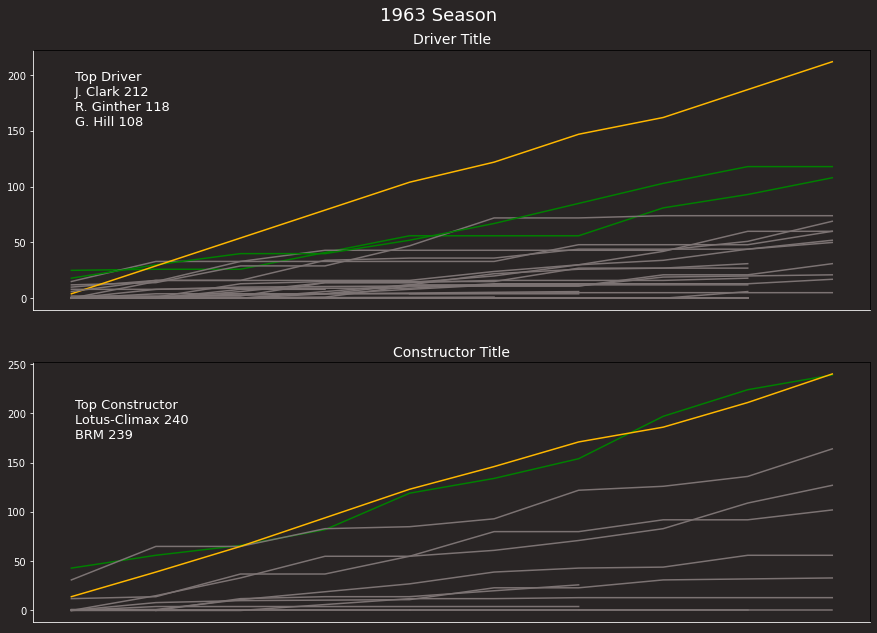

In [9]:
plot_season(res, 1963, n_drivers=3, n_ctr=2, 
            drv_colors=[clrs['BRM'], clrs['BRM'], clrs['Lotus']], 
            ctr_colors=[clrs['BRM'], clrs['Lotus']])

This was a legendary season for Jim Clark, winning in his Lotus 70% of the races, finishing on the podium 90% of the times. An absolutely dominant season. On the other hand, the 2 BRM drivers created quite a challenge for the constructor title, finishing on the podium in every race that year. If the victory of Jim Clark was evident since the early races, we had to wait until the very last race to see Lotus taking the title by only 1 point.

We move forward a couple of decades and find the above mentioned 1982 season.

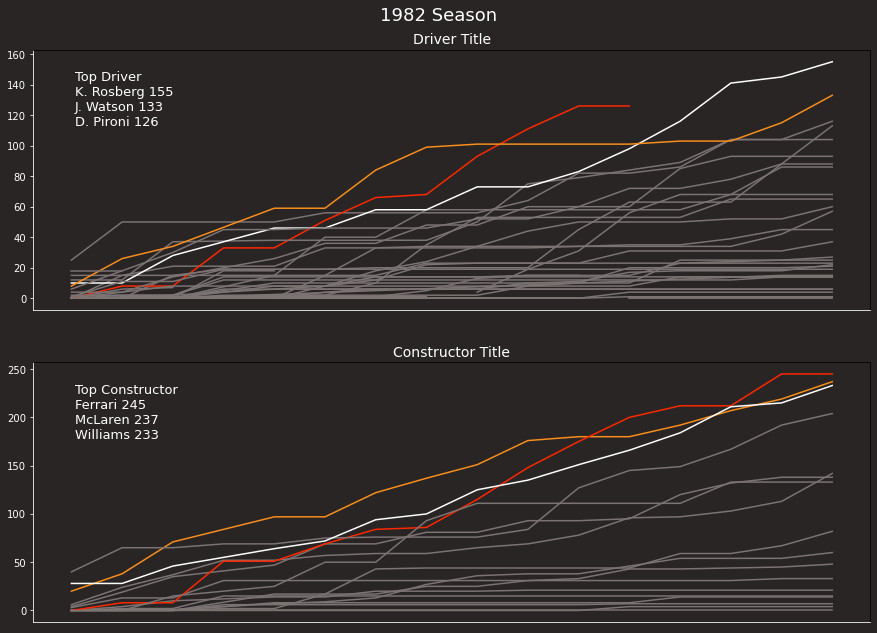

In [10]:
plot_season(res, 1982, n_drivers=3, n_ctr=3, 
            drv_colors=[clrs['Ferrari'], clrs['Williams'], clrs['McLaren']], 
            ctr_colors=[clrs['McLaren'], clrs['Ferrari'], clrs['Williams']])

This season started with the drivers going on a strike 3 days before the very first race. Then another protest led by Bernie Ecclestone produced a San Marino Gran Prix with very few cars racing, but also with a great battle between the 2 Ferrari of Didier Pironi and Gilles Villeneuve. Tragically, during free practice of the very next Gran Prix in Belgium, Villeneuve lost his life in a crash. That Gran Prix was the beginning of a quite consistent series of good results, getting with his McLaren on the podium 3 times in 4 races. Hovewer, after the Canadian Gran Prix he struggled in getting his car in the point zone. 

After the tragic weekend in Belgium, Ferrari driver Didier Pironi got on the podium 5 times out of 6 races but a big incident during practice at the German Gran Prix ended his F1 career.

This hectic season was eventually won by Keke Rosberg in the Williams, in one of the most uncertain and tragic seasons in F1 history.

A few year later, we can again observe a dominant season. It is 1988 and Prost and Senna are driving for McLaren.

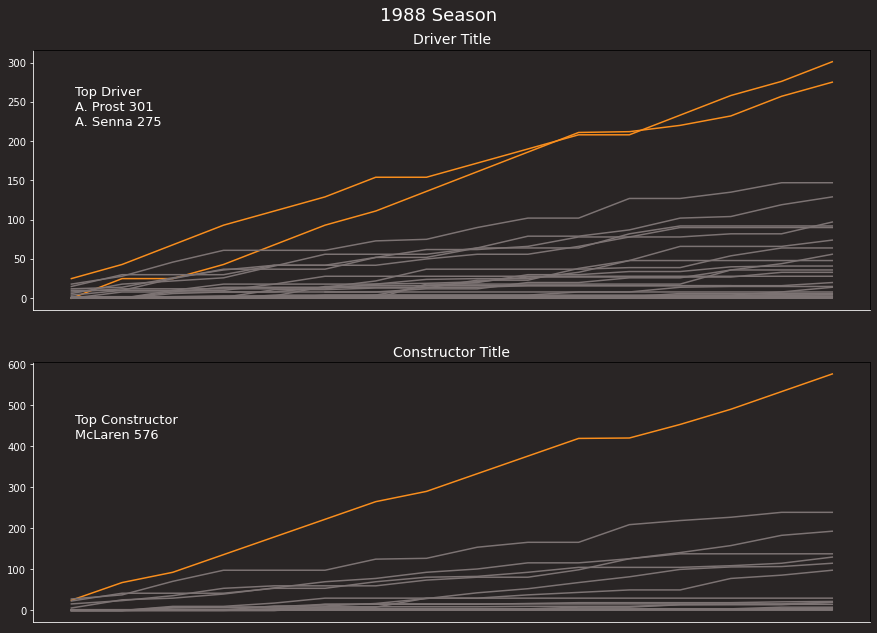

In [11]:
plot_season(res, 1988, n_drivers=2, n_ctr=1, 
            drv_colors=[clrs['McLaren'], clrs['McLaren']], 
            ctr_colors=[clrs['McLaren']])

McLaren won 93% of the races in 1988, 50% for Senna, 43% for Prost. This produced one of the most legendary rivarlies in F1 history, where the 2 drivers went head to head until the very end while the rest of the field was pretty much a spectator, unable to compete.

Even more extreme was 2002 season.

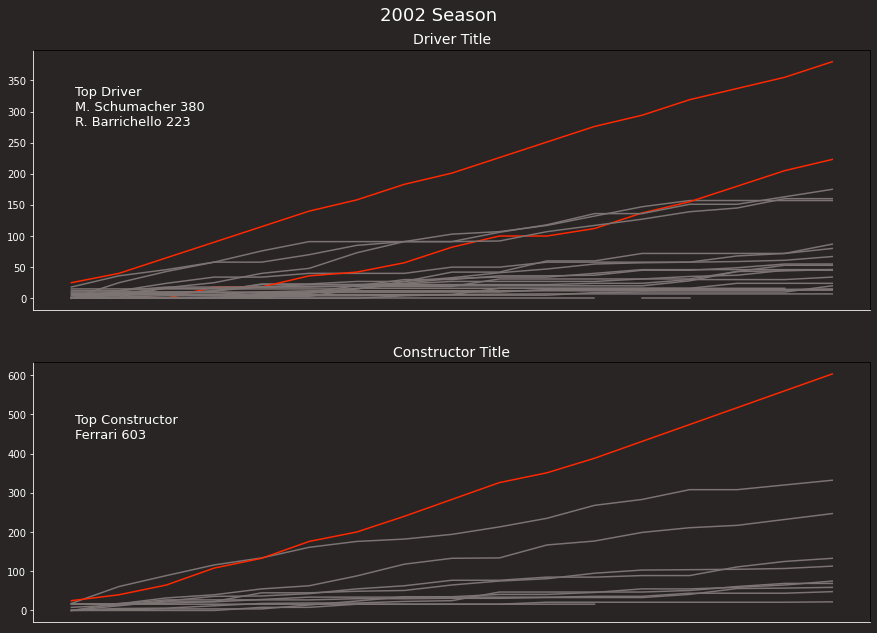

In [12]:
plot_season(res, 2002, n_drivers=2, n_ctr=1, 
            drv_colors=[clrs['Ferrari'], clrs['Ferrari']], 
            ctr_colors=[clrs['Ferrari']])

Ferrari won *only* 88% of the races, but Michael Schumacher was on the podium every race that year and on the highest step of the podium 63% of the times. Seasons like this one or the 2004 season led to a series of regulation changes and Ferrari was never able to reproduce that level of dominance. New players came into the picture.

For example, in 2009 we see the triunphant debut of Brown GP.

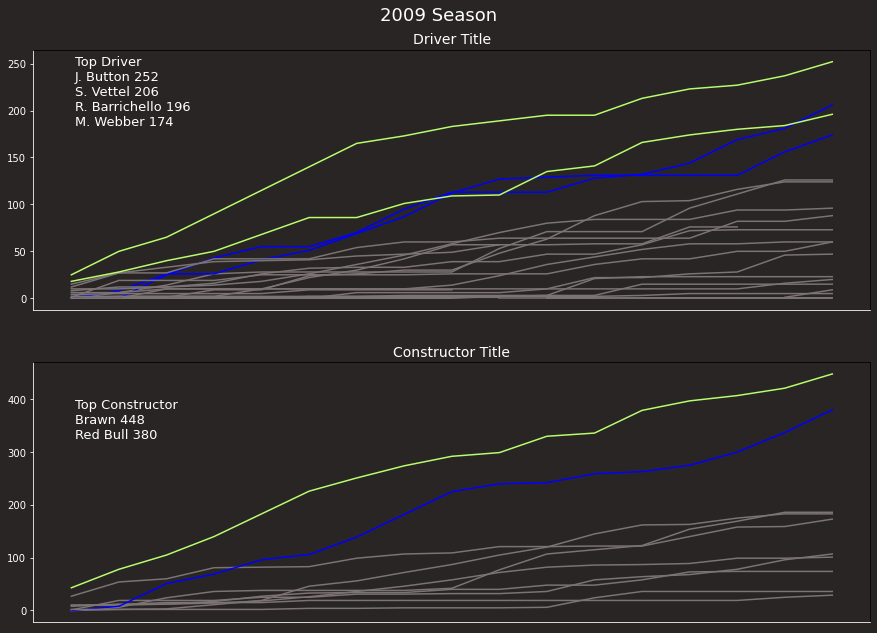

In [13]:
plot_season(res, 2009, n_drivers=4, n_ctr=2, 
            drv_colors=[clrs['Brawn'], clrs['Red Bull'], clrs['Red Bull'], clrs['Brawn']], 
            ctr_colors=[clrs['Red Bull'], clrs['Brawn']])

A technical advantage gave the rookie team a 6-win streak and a substantial early advantage that the main rival Red Bull was unable to close.

Red Bull did not have to wait long to start winning championships but the way those championships were achieved changes a lot year by year. For example, in 2012 we see a thrilling battle between the Ferrari of Fernando Alonso and the Red Bull of Sebastian Vettel

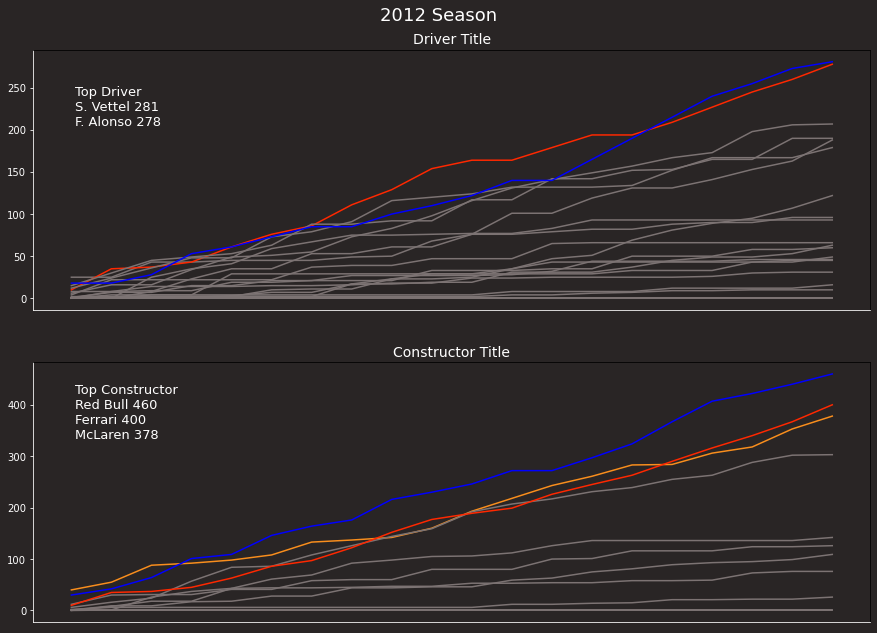

In [14]:
plot_season(res, 2012, n_drivers=2, n_ctr=3, 
            drv_colors=[clrs['Ferrari'], clrs['Red Bull']], 
            ctr_colors=[clrs['McLaren'], clrs['Red Bull'], clrs['Ferrari']])

Despite Alonso being more consistent (on the podium 65% of the times vs the 50% of Vettel), it was Vettel to get the title at the end. On the custroctor side, we can also see how McLaren (with a young Lewis Hamilton) threw its hat in the ring and challenged Ferrari for the second spot in the championship.

On the other hand, only one year later showed how unbeatable Vettel and Red Bull were

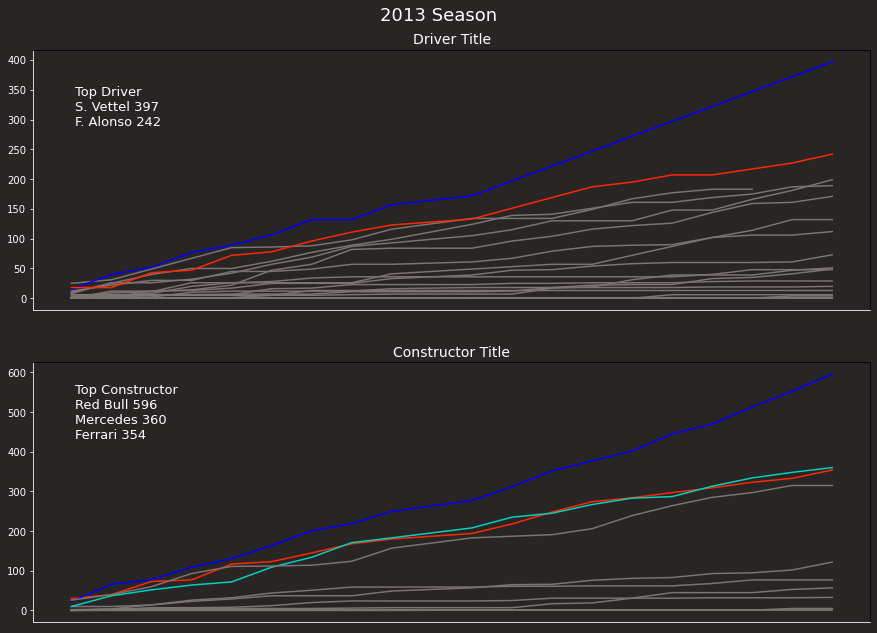

In [15]:
plot_season(res, 2013, n_drivers=2, n_ctr=3, 
            drv_colors=[clrs['Red Bull'], clrs['Ferrari']], 
            ctr_colors=[clrs['Ferrari'], clrs['Red Bull'], clrs['Mercedes']])

Vettel went to the podium 84% of the times and won 64% of the races, the rivalry with Alonso was unfortunately not seen again.

After the Red Bull era, the Mercedes one begun and it is still in progress. In particular, the 2015 season showed how big of a difference there was with the rest of the field, winning 84% of the races with the 2 superstars Lewis Hamilton and Nico Rosberg

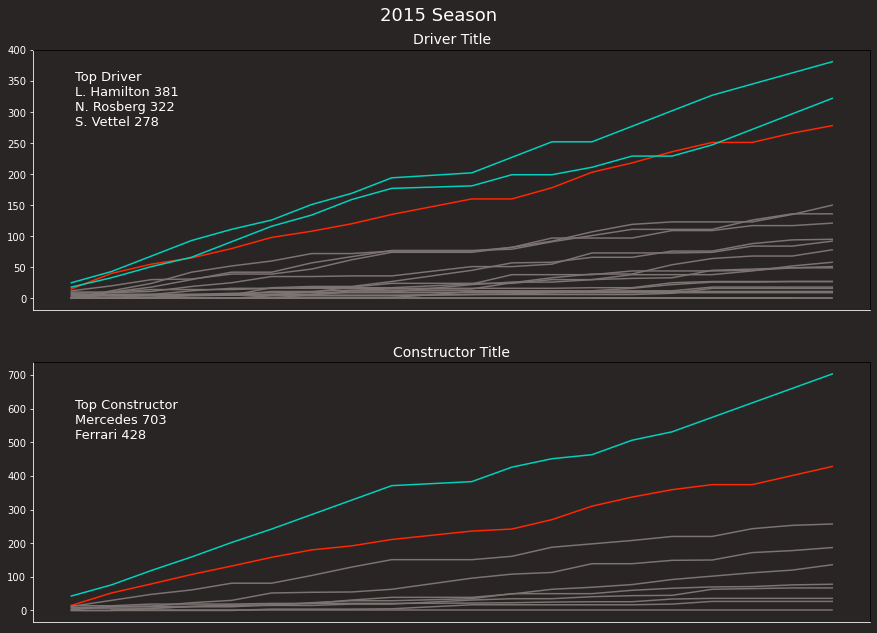

In [16]:
plot_season(res, 2015, n_drivers=3, n_ctr=2, 
            drv_colors=[clrs['Mercedes'], clrs['Ferrari'], clrs['Mercedes']], 
            ctr_colors=[clrs['Ferrari'], clrs['Mercedes']])

Before moving on, let's have a look at how the 2020 season is unfolding

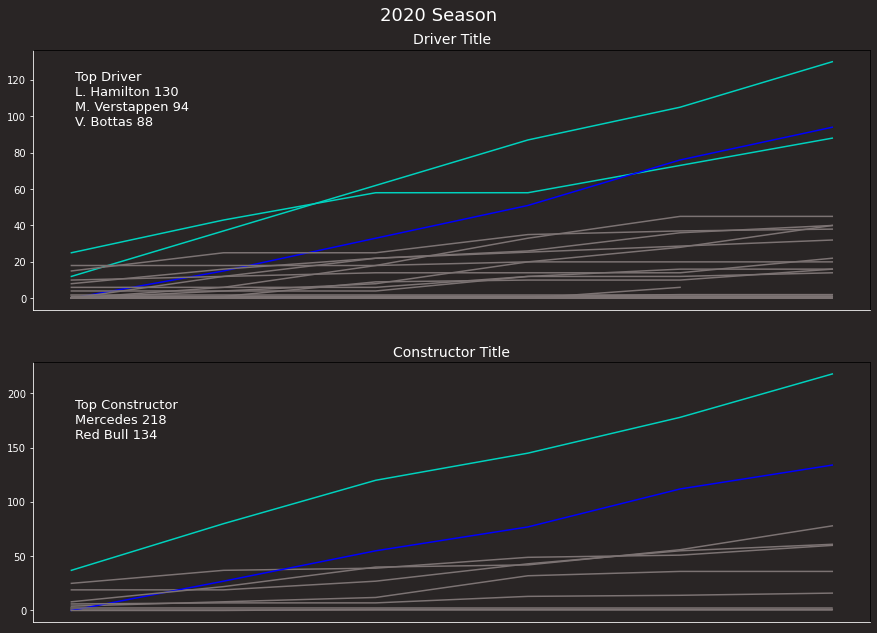

In [17]:
plot_season(res, 2020, n_drivers=3, n_ctr=2, 
            drv_colors=[clrs['Mercedes'], clrs['Red Bull'], clrs['Mercedes']], 
            ctr_colors=[clrs['Red Bull'], clrs['Mercedes']])

# The Best Gran Prix

We can define the net number of overtakes of a driver as the difference between starting and finishing positions. For how limited, this can give us a measure of how thrilling a race was.

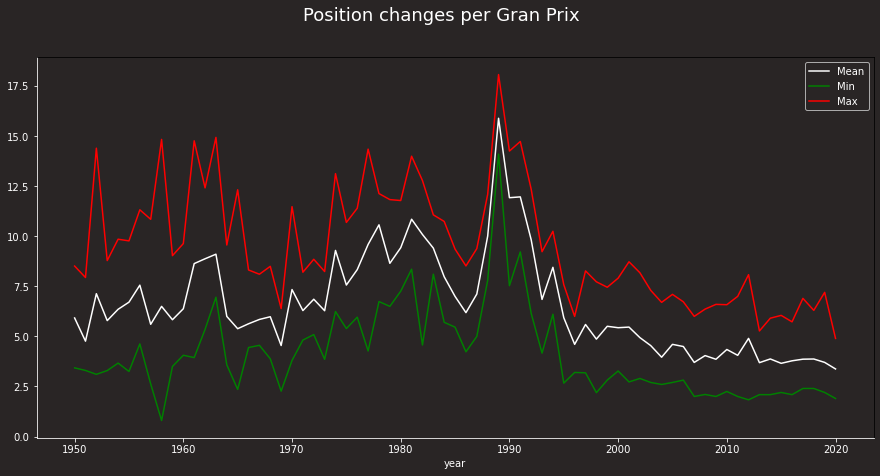

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7), facecolor='#292525')
fig.suptitle(f'Position changes per Gran Prix', fontsize=18, color='w')

(res.groupby(['year', 'circuitRef']).abs_gain.sum() / res.groupby(['year', 'circuitRef']).size()).groupby('year').mean().plot(label='Mean', color='w')
(res.groupby(['year', 'circuitRef']).abs_gain.sum() / res.groupby(['year', 'circuitRef']).size()).groupby('year').min().plot(label='Min', color='g')
(res.groupby(['year', 'circuitRef']).abs_gain.sum() / res.groupby(['year', 'circuitRef']).size()).groupby('year').max().plot(label='Max', color='r')

leg = ax.legend(facecolor="#292525")
for text in leg.get_texts():
    text.set_color("w")

ax = plot_frame(ax)

We can see how 1989 was a season with a lot of position changes and how after the mid-90s the sport pretty much settled to a relatively low value, where even the most thrilling (under this definition) Gran Prix of each year failed in reaching the levels of the 70s and 80s.

On the other hand, if we consider the proportion of drivers that finished the race with the same number of laps as the race leader, we can see both how the cars became more reliable and how the difference between the top teams and the rest got smaller, on average.

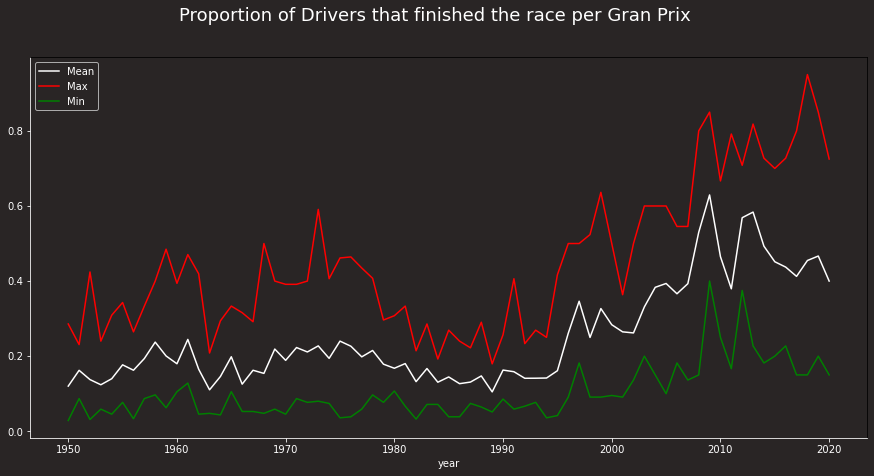

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7), facecolor='#292525')
fig.suptitle(f'Proportion of Drivers that finished the race per Gran Prix', fontsize=18, color='w')

res.groupby(['year', 'circuitRef']).finished.mean().groupby('year').mean().plot(color='w', label='Mean')
res.groupby(['year', 'circuitRef']).finished.mean().groupby('year').max().plot(color='r', label='Max')
res.groupby(['year', 'circuitRef']).finished.mean().groupby('year').min().plot(color='g', label='Min')

leg = ax.legend(facecolor="#292525")
for text in leg.get_texts():
    text.set_color("w")

ax = plot_frame(ax)

If we look at the races more in detail, we can see the proportion of laps in each race when a position change happened (either via overtake, accident, mistake, or pit stop). Unfortunately, we have only have data starting 1996, which is the beginning of the negative trend seen in the plots above.

However, we notice that in 2011,  which is also the year of the introduction of the **Drag Reduction System (DRS)**, we have a significant increase in the proportion of laps with at least a position change, going from the 51% of 2010 to the 73% of 2011.

In [20]:
laps = laps.sort_values(by=['raceId', 'driverId', 'lap'])
laps['pos_change'] = -laps.groupby(['raceId', 'driverId']).position.diff().fillna(0)
laps['abs_change'] = abs(laps['pos_change'])

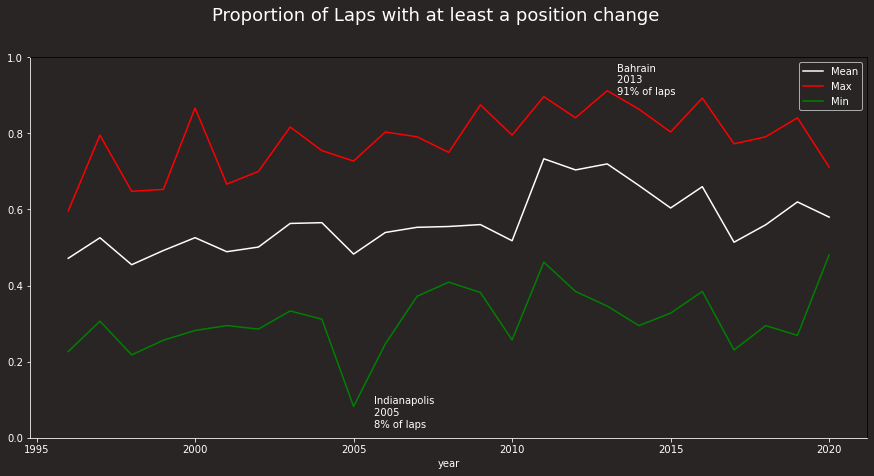

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7), facecolor='#292525')
fig.suptitle(f'Proportion of Laps with at least a position change', fontsize=18, color='w')

tmp = laps.groupby(['year', 'raceId', 'circuitRef', 'lap'], as_index=False).abs_change.sum()
tmp['lap_with_change'] = np.sign(tmp.abs_change)

tmp.groupby(['year', 'raceId', 'circuitRef']).lap_with_change.mean().groupby('year').agg(['mean', 'max', 'min']).plot(ax=ax, color=['w', 'r', 'g'])

leg = ax.legend(facecolor="#292525")
leg.get_texts()[0].set_text('Mean')
leg.get_texts()[1].set_text('Max')
leg.get_texts()[2].set_text('Min')
for text in leg.get_texts():
    text.set_color("w")
    
text = f'Indianapolis \n2005 \n8% of laps'
ax.annotate(text, xy=(2005, 0.08), xycoords='data', xytext=(20,-20), textcoords='offset points', color='w')
text = f'Bahrain \n2013 \n91% of laps'
ax.annotate(text, xy=(2013, 0.91), xycoords='data', xytext=(10,-3), textcoords='offset points', color='w')

ax.set_ylim((0,1))    
ax = plot_frame(ax)

We can also easily spot the most boring race in recent history: Indianapolis 2005. Only 8% of the laps with a position change and expectedly so: due to a problem with the tyres made by Michelin, only 6 cars were allowed to race that day.

On the other extreme, we find Bahrain 2013, with 91% of laps with at least a position change.

Clearly, if we focus only on the top 3 positions of each lap, the numbers go down quite a bit, with the 2011 Belgian Gran Prix being the most exciting race under this statistic.

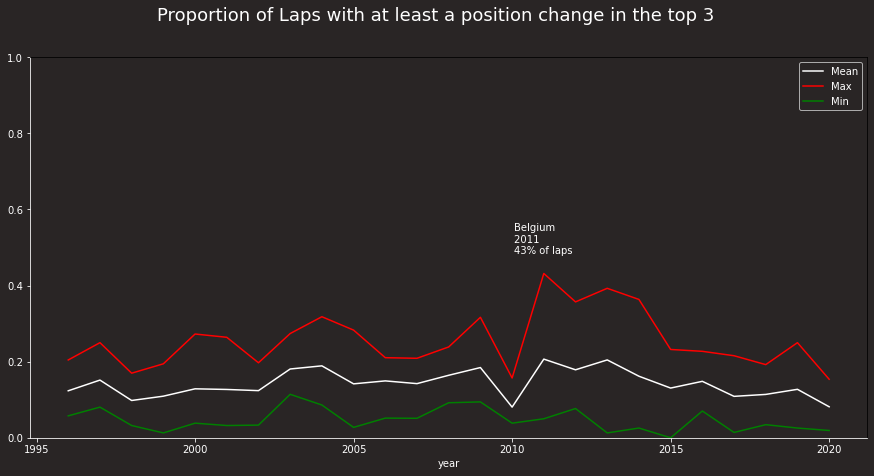

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7), facecolor='#292525')
fig.suptitle(f'Proportion of Laps with at least a position change in the top 3', fontsize=18, color='w')

tmp = laps[laps.position <= 3].groupby(['year', 'raceId', 'circuitRef', 'lap'], as_index=False).abs_change.sum()
tmp['lap_with_change'] = np.sign(tmp.abs_change)

tmp.groupby(['year', 'raceId', 'circuitRef']).lap_with_change.mean().groupby('year').agg(['mean', 'max', 'min']).plot(ax=ax, color=['w', 'r', 'g'])

leg = ax.legend(facecolor="#292525")
leg.get_texts()[0].set_text('Mean')
leg.get_texts()[1].set_text('Max')
leg.get_texts()[2].set_text('Min')
for text in leg.get_texts():
    text.set_color("w")
    
text = f'Belgium \n2011 \n43% of laps'
ax.annotate(text, xy=(2011, 0.43), xycoords='data', xytext=(-30,20), textcoords='offset points', color='w')


ax.set_ylim((0,1))    
ax = plot_frame(ax)

In all of this, 2020 is not being a particularly bad year, if we do not consider the position changes in the top 3. The close competition in the mid field is making most races very enjoyable.

# Conclusions